# Eigenvalues and eigenvectors of the Laplacian on the unit square

In [1]:
from fenics import *
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

In [2]:
# Make some matrices and a weight
class Coeff(UserExpression):
    def __init__(self, c, **kwargs):
        super().__init__(**kwargs)
        self._c = c
        
    def eval(self, values, x):
        values[0] = self._c
        values[1] = 0.0
        values[2] = 0.0
        values[3] = self._c
        
    def value_shape(self):
        return (2,2)

class Weight(UserExpression):
    def __init__(self, c, **kwargs):
        super().__init__(**kwargs)
        self._c = c
        
    def eval(self, values, x):
        values[0] = self._c

    def value_shape(self):
        return ()
        

In [8]:
# Mesh and function space
N = 10
mesh = UnitSquareMesh(N, N)
V = FunctionSpace(mesh, "Lagrange", 1)
u = TrialFunction(V)
v = TestFunction(V)

# The problem
# Can compute div(C(grad(u))) = \lambda u w.r.t. to weighted measure w dx
#C = Coeff(1.0)
#w = Weight(1.0)
#a = inner(C*grad(u), grad(v)) * w * dx
#b = inner(u, v) * w * dx
a = inner(grad(u), grad(v)) * dx
b = inner(u, v) * dx
dummy = inner(Constant(1), v)*dx
bc = DirichletBC(V, Constant(0.0), 'on_boundary')

# Assemble finite element matrices
A = PETScMatrix()
assemble_system(a, dummy, bc, A_tensor=A)
B = PETScMatrix()
#assemble_system(b, dummy, bc, A_tensor=B)
assemble(b, B);

In [9]:
# Set up the solver
solver = SLEPcEigenSolver(A, B)
solver.parameters["solver"] = "krylov-schur"
solver.parameters["problem_type"] = "gen_hermitian"

In [10]:
# Solve the system
solver.solve()

In [12]:
# A triangular mesh produces a (N+1)^2 dimension vector space so we expect that many eigenvalues
M = solver.get_number_converged()
M == (N+1)**2

True

In [13]:
# Obtain the eigevalues
approx_spectrum = np.sort(np.asarray([solver.get_eigenvalue(i)[0] for i in range(solver.get_number_converged())]))
approx_spectrum

array([  20.22544679,   51.39887671,   52.62570883,   86.33264122,
        108.0052857 ,  108.5607696 ,  141.6453112 ,  152.35891453,
        192.64037282,  193.65723628,  207.38194651,  236.14264348,
        246.24669614,  289.29651919,  310.6422713 ,  311.3879337 ,
        324.34516055,  362.19772327,  374.71428735,  385.25481791,
        434.82836142,  462.44611447,  463.86409327,  471.7390736 ,
        494.13061584,  523.81944841,  535.22934275,  557.97141917,
        606.06458418,  606.31322076,  645.59478179,  646.4142169 ,
        651.30869502,  693.65126408,  696.39158716,  721.59779134,
        722.40969715,  736.52712491,  790.92623167,  809.45419189,
        835.55570358,  843.29418406,  849.7827097 ,  856.07087971,
        858.10229847,  925.06526495,  925.36002735,  929.0958237 ,
        968.54770769,  989.60303322,  990.93936977, 1032.92435477,
       1055.75292454, 1058.95424502, 1076.38236917, 1095.17556463,
       1134.58679809, 1139.08846775, 1139.83934226, 1150.53574

In [14]:
# Analytic spectrum
pairs = np.asarray([[[i, j, i**2 + j**2] for i in range(1,N+2)] for j in range(1,N+2)]).reshape((N+1)**2, 3)
exact_spectrum = (np.pi)**2 * np.sort(pairs[:,2])
exact_spectrum

array([  19.7392088 ,   49.34802201,   49.34802201,   78.95683521,
         98.69604401,   98.69604401,  128.30485721,  128.30485721,
        167.78327482,  167.78327482,  177.65287922,  197.39208802,
        197.39208802,  246.74011003,  246.74011003,  256.60971443,
        256.60971443,  286.21852763,  286.21852763,  315.82734083,
        335.56654964,  335.56654964,  365.17536284,  365.17536284,
        394.78417604,  394.78417604,  404.65378044,  404.65378044,
        444.13219805,  444.13219805,  493.48022005,  493.48022005,
        493.48022005,  513.21942886,  513.21942886,  523.08903326,
        523.08903326,  572.43705526,  572.43705526,  602.04586847,
        602.04586847,  641.52428607,  641.52428607,  641.52428607,
        641.52428607,  671.13309927,  671.13309927,  710.61151688,
        720.48112128,  720.48112128,  730.35072568,  730.35072568,
        789.56835209,  789.56835209,  809.30756089,  809.30756089,
        838.91637409,  838.91637409,  838.91637409,  838.91637

In [9]:
# Max difference between analytic and computed spectrum

(np.abs((exact_spectrum-approx_spectrum)/exact_spectrum)).max()

0.535472367121016

In [15]:
# Plot of analytic and computed spectrum

dfexact = pd.DataFrame({"index": np.sort(pairs[:,2]), "spectrum": exact_spectrum, "scheme": "exact"})

# Get the index for the computed spectrum assuming is approximately pi^2(n^2+m^2)
approx_index = np.round((1/np.pi**2) * approx_spectrum)
dfapprox = pd.DataFrame({"index": approx_index, "spectrum": approx_spectrum, "scheme": "approx"})
df = pd.concat([dfexact, dfapprox])

fig = px.scatter(df, x="index", y="spectrum", color="scheme")
fig.show()

In [11]:
r, c, ur, rc = solver.get_eigenpair(M-4)

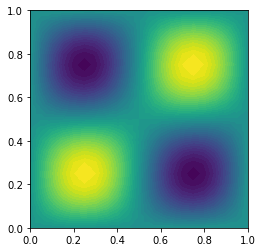

In [12]:
u = Function(V)
u.vector()[:] = ur
plot(u)

In [13]:
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

U = np.vectorize(lambda x, y: u(x, y))
Zapprox = U(X, Y)

In [14]:
n=2
m=2
Zexact = 2*np.sin(m*np.pi*X)*np.sin(n*np.pi*Y)

In [15]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'surface'}, {'type': 'surface'}]], )
fig.add_trace(
    go.Surface(x=x, y=y, z=Zapprox),
    row=1, col=1
)

fig.add_trace(
    go.Surface(x=x, y=y, z=Zexact),
    row=1, col=2
)

fig.show(render="pdf")

In [18]:
np.sort(pairs[:,2])

array([  2,   5,   5,   8,  10,  10,  13,  13,  17,  17,  18,  20,  20,
        25,  25,  26,  26,  29,  29,  32,  34,  34,  37,  37,  40,  40,
        41,  41,  45,  45,  50,  50,  50,  52,  52,  53,  53,  58,  58,
        61,  61,  65,  65,  65,  65,  68,  68,  72,  73,  73,  74,  74,
        80,  80,  82,  82,  85,  85,  85,  85,  89,  89,  90,  90,  97,
        97,  98, 100, 100, 101, 101, 104, 104, 106, 106, 109, 109, 113,
       113, 116, 116, 117, 117, 122, 122, 125, 125, 125, 125, 128, 130,
       130, 130, 130, 136, 136, 137, 137, 145, 145, 145, 145, 146, 146,
       148, 148, 149, 149, 153, 153, 157, 157, 160, 160, 162, 164, 164,
       169, 169, 170, 170, 170, 170, 173, 173, 178, 178, 180, 180, 181,
       181, 185, 185, 185, 185, 193, 193, 194, 194, 197, 197, 200, 200,
       200, 202, 202, 205, 205, 205, 205, 208, 208, 212, 212, 218, 218,
       221, 221, 221, 221, 225, 225, 226, 226, 229, 229, 232, 232, 233,
       233, 234, 234, 241, 241, 242, 244, 244, 245, 245, 250, 25